# Structural Query for *De Novo* Binder Design

This Jupyter Notebook performs a structural query to identify optimal PDB structures for *de novo* protein binder design. The pipeline consists of multiple steps:

1. **Setup** – Import necessary libraries, define constants, and initialize functions.
2. **Search** – Query the RCSB PDB database to retrieve membrane protein structures that meet specific criteria.
3. **Filtering** – Process search results and remove structures that do not meet quality standards.
4. **Processing** – Analyze filtered structures to identify suitable truncations and hydrophobic hotspots.
5. **Output** – Generate and store the final dataset in JSON format, including relevant visualizations.

## Setup

The first section initializes the notebook by:
- Importing required **libraries** (e.g., `logging`, `urllib3`, `json`, `matplotlib`, `seaborn`, `sparqlwrapper`, and `biopython`).
- Defining **global constants** (e.g., API endpoints, filtering queries, color scheme).
- Implementing **utility functions** to handle HTTP requests, data processing, and visualization.

The conda environment configuration is specified in `conda.yml`.

In [1]:
### IMPORT MODULES

import logging
import urllib3
import urllib.parse
import json
from typing import Any, cast

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_set_diagrams import EulerDiagram
import matplotlib.patheffects as path_effects

from SPARQLWrapper import SPARQLWrapper, JSON
from Bio.PDB import PDBList, FastMMCIFParser, Structure, is_aa

In [2]:
### GLOBAL CONSTANTS

DEFAULT_CLIENT = urllib3.PoolManager()

API_ENDPOINT = {
    "rcsb/search": "https://search.rcsb.org/rcsbsearch/v2/query",
    "rcsb/data": "https://data.rcsb.org/graphql",
    "rcsb/entry": "https://data.rcsb.org/rest/v1/core/entry",
    "rcsb/assembly": "https://data.rcsb.org/rest/v1/core/assembly",
    "rcsb/entity/branched": "https://data.rcsb.org/rest/v1/core/branched_entity",
    "rcsb/entity/polymer": "https://data.rcsb.org/rest/v1/core/polymer_entity",
    "rcsb/entity/non-polymer": "https://data.rcsb.org/rest/v1/core/non-polymer_entity",
    "uniprot/search": "https://rest.uniprot.org/uniprotkb/stream",
    "uniprot/data": "https://sparql.uniprot.org/sparql",
    "uniprot/features": "https://www.ebi.ac.uk/proteins/api/features",
    "alphafold/entry": "https://alphafold.ebi.ac.uk/api/prediction"
}

RCSB_SEARCH_QUERY = {
    "query": {
        "type": "terminal",
        "service": "text"
    },
    "request_options": {
        "results_verbosity": "compact",
        "return_all_hits": True
    },
    "return_type": "entry"
}

RCSB_DATA_QUERY = {
    "query": """
    query($ids: [String!]!) {
        entries(entry_ids: $ids) {
            entry {
                id
            }
            citation {
                pdbx_database_id_DOI
            }
            rcsb_entry_info {
                polymer_entity_count
                polymer_entity_count_protein
                resolution_combined
            }
            polymer_entities {
                entity_poly {
                    pdbx_seq_one_letter_code_can
                    rcsb_sample_sequence_length
                }
                rcsb_polymer_entity_container_identifiers {
                    entity_id
                }
                rcsb_polymer_entity_container_identifiers {
                    asym_ids
                    auth_asym_ids
                    uniprot_ids
                }
                rcsb_polymer_entity_feature {
                    type
                    name
                    feature_id
                    feature_positions {
                        beg_seq_id
                        end_seq_id
                        values
                    }
                }
            }
        }
    }
    """,
    "variables": dict()
}

UNIPROT_DATA_QUERY = """
    PREFIX up: <http://purl.uniprot.org/core/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

    SELECT (?protein AS ?uniprot)
        (GROUP_CONCAT(DISTINCT ?entry; SEPARATOR=", ") AS ?rcsb)
        (GROUP_CONCAT(DISTINCT ?alphafold; SEPARATOR=", ") AS ?alphafold)
        (GROUP_CONCAT(DISTINCT ?annotationtype; SEPARATOR=", ") AS ?annotations)

    WHERE {
        VALUES (?entry) { $entries }
        BIND (IRI(CONCAT("http://purl.uniprot.org/pdbsum/", ?entry)) AS ?pdb)

        ?protein a up:Protein .
        ?protein rdfs:seeAlso ?pdb .
        ?pdb up:database <http://purl.uniprot.org/database/PDBsum> .

        OPTIONAL { 
            ?protein rdfs:seeAlso ?alphafold . 
            ?alphafold up:database <http://purl.uniprot.org/database/AlphaFoldDB> . 
        }

        OPTIONAL {
            ?protein up:annotation ?annotation . 
            ?annotation rdf:type ?annotationtype .
        }
    }

    GROUP BY ?protein
"""

UNIPROT_FEATURES_QUERY = {
    "size": -1,
    "types": ",".join(["TOPO_DOM", "TRANSMEM", "HELIX", "TURN", "STRAND"])
}

TUM_BLUE_GRADIENT = "blend:#0A2D57,#3070B3,#E3EEFA"

In [3]:
### GLOBAL VARIABLES

result = {
    "search": dict(),
    "filter": dict(),
    "summary": dict(),
    "data": dict()
}

data = dict()

In [4]:
### FUNCTIONS


## Search

The **search step** queries **PDB structures** based on predefined selection criteria.  
Each retrieved PDB entry must satisfy the following conditions:

- **Membrane proteins**: structure must belong to a membrane protein as annotated by common membrane protein databases.
- **Taxonomy**: protein must originate from *Drosophila melanogaster* or *Homo sapiens*.
- **Acquisition method**: only Electron Microscopy (EM) structures are considered.
- **Resolution**: 3.5 Å or better (i.e., resolution ≤ 3.5 Å).
- **Journal**: original citation for the structure must originate from specific journals.
- **Composition**: structure must belong to a homomeric or heteromeric protein.
- **Multimericity**: only **monomeric proteins** are selected (polimeric count = 1).

Intersection of the described search subsets forms the final search result set of PDB entries.

In [5]:
### SEARCH: ANNOTATION

RCSB_SEARCH_QUERY["query"]["parameters"] = {
    "attribute": "rcsb_polymer_entity_annotation.type",
    "operator": "in",
    "value": [
        "PDBTM",
        "MemProtMD",
        "OPM",
        "mpstruc"
    ]
}

response = DEFAULT_CLIENT.request(
    method="POST",
    url=API_ENDPOINT["rcsb/search"],
    json=RCSB_SEARCH_QUERY
)

if response.status == 200:
    result["search"]["annotation"] = json.loads(response.data.decode("utf8"))["result_set"]
else:
    logging.error("Failed to query RCSB search API")
    logging.error(response.data.decode("utf8"))

In [6]:
### SEARCH: ORGANISM

RCSB_SEARCH_QUERY["query"]["parameters"] = {
    "attribute": "rcsb_entity_source_organism.taxonomy_lineage.name",
    "operator": "in",
    "value": [
        "Drosophila melanogaster",
        "Homo sapiens"
    ]
}

response = DEFAULT_CLIENT.request(
    method="POST",
    url=API_ENDPOINT["rcsb/search"],
    json=RCSB_SEARCH_QUERY
)

if response.status == 200:
    result["search"]["organism"] = json.loads(response.data.decode("utf8"))["result_set"]
else:
    logging.error("Failed to query RCSB search API")
    logging.error(response.data.decode("utf8"))

In [7]:
### SEARCH: ACQUISITION METHOD

RCSB_SEARCH_QUERY["query"]["parameters"] = {
    "attribute": "exptl.method",
    "operator": "exact_match",
    "value": "ELECTRON MICROSCOPY"
}

response = DEFAULT_CLIENT.request(
    method="POST",
    url=API_ENDPOINT["rcsb/search"],
    json=RCSB_SEARCH_QUERY
)

if response.status == 200:
    result["search"]["acquisition"] = json.loads(response.data.decode("utf8"))["result_set"]
else:
    logging.error("Failed to query RCSB search API")
    logging.error(response.data.decode("utf8"))

In [8]:
### SEARCH: RESOLUTION

RCSB_SEARCH_QUERY["query"]["parameters"] = {
    "attribute": "rcsb_entry_info.resolution_combined",
    "operator": "less_or_equal",
    "value": 3.5
}

response = DEFAULT_CLIENT.request(
    method="POST",
    url=API_ENDPOINT["rcsb/search"],
    json=RCSB_SEARCH_QUERY
)

if response.status == 200:
    result["search"]["resolution"] = json.loads(response.data.decode("utf8"))["result_set"]
else:
    logging.error("Failed to query RCSB search API")
    logging.error(response.data.decode("utf8"))

In [9]:
### SEARCH: JOURNAL

# RCSB_SEARCH_QUERY["query"]["parameters"] = {
#     "attribute": "rcsb_primary_citation.rcsb_journal_abbrev",
#     "operator": "in",
#     "value": [
#         "Nat Struct Mol Biol",
#     ]
# }

# response = DEFAULT_CLIENT.request(
#     method="POST",
#     url=API_ENDPOINT["rcsb/search"],
#     json=RCSB_SEARCH_QUERY
# )

# if response.status == 200:
#     result["search"]["journal"] = json.loads(response.data.decode("utf8"))["result_set"]
# else:
#     logging.error("Failed to query RCSB search API")
#     logging.error(response.data.decode("utf8"))

In [10]:
### SEARCH: COMPOSITION

RCSB_SEARCH_QUERY["query"]["parameters"] = {
    "attribute": "rcsb_entry_info.polymer_composition",
    "operator": "in",
    "value": [
        "heteromeric protein",
        "homomeric protein"
    ]
}

response = DEFAULT_CLIENT.request(
    method="POST",
    url=API_ENDPOINT["rcsb/search"],
    json=RCSB_SEARCH_QUERY
)

if response.status == 200:
    result["search"]["composition"] = json.loads(response.data.decode("utf8"))["result_set"]
else:
    logging.error("Failed to query RCSB search API")
    logging.error(response.data.decode("utf8"))

In [11]:
### SEARCH: MULTIMERICITY

RCSB_SEARCH_QUERY["query"]["parameters"] = {
    "attribute": "rcsb_entry_info.deposited_polymer_entity_instance_count",
    "operator": "equals",
    "value": 1
}

response = DEFAULT_CLIENT.request(
    method="POST",
    url=API_ENDPOINT["rcsb/search"],
    json=RCSB_SEARCH_QUERY
)

if response.status == 200:
    result["search"]["multimericity"] = json.loads(response.data.decode("utf8"))["result_set"]
else:
    logging.error("Failed to query RCSB search API")
    logging.error(response.data.decode("utf8"))

In [12]:
### COMBINE SEARCH RESULTS

result["summary"]["search"] = list(set.intersection(*map(set, result["search"].values())))

## Filtering

The PDB entries from the search are **filtered** to ensure high data quality.
The filtering pipeline consists of multiple steps:

- **Entity validation**: Ensure that each PDB entry contains*one and exactly one polymeric protein entity.
- **Uniqueness check**: identify and retain only one representative structure per protein.
- **Cross-references to UniProt**: verify that a unique UniProt accession is associated with each PDB entry.
- **Cross-references to AlphaFoldDB**: ensure that the protein has a corresponding AlphaFold model.
- **Hydropathy index**: check whether a hydropathy index is available for the protein.
- **Disordered regions**: confirm that disordered regions are defined and annotated.
- **Secondary structure**: ensure that secondary structure elements (e.g., α-helices, β-strands, turns) are annotated.
- **Topology Information**: validate whether transmembrane, cytoplasmic, and extracellular annotations exist.

Each of these filtering steps helps refine the dataset to contain only high-quality, well-annotated protein structures.

In [13]:
### GET RCSB DATA

RCSB_DATA_QUERY["variables"] = {
    "ids": result["summary"]["search"]
}

response = DEFAULT_CLIENT.request(
    method="POST",
    url=API_ENDPOINT["rcsb/data"],
    json=RCSB_DATA_QUERY
)

if response.status == 200:
    data["rcsb"] = json.loads(response.data.decode("utf8"))["data"]["entries"]
else:
    logging.error("Failed to query RCSB data API")
    logging.error(response.data.decode("utf8"))

In [14]:
### GET UNIPROT DATA

UNIPROT_DATA_QUERY = UNIPROT_DATA_QUERY.replace(
    "$entries", " ".join(f"('{id}')" for id in result["summary"]["search"])
)

sparql = SPARQLWrapper(API_ENDPOINT["uniprot/data"])
sparql.setQuery(UNIPROT_DATA_QUERY)
sparql.setReturnFormat(JSON)

data["uniprot"] = cast(dict[str, Any], sparql.query().convert())["results"]["bindings"]

In [15]:
### FILTER: REPRESENTATIVE

result["filter"]["representative"] = []
mapping = dict()

for protein in data["uniprot"]:
    accession = protein["uniprot"]["value"]
    entries = protein["rcsb"]["value"].split(", ")
    representative = None
    resolution = float("inf")

    for entry in entries:
        info = next((elem for elem in data["rcsb"] if elem["entry"]["id"] == entry), None)

        if info is None:
            continue

        if current := info["rcsb_entry_info"]["resolution_combined"][0] < resolution:
            resolution = current
            representative = entry

    if representative:
        result["filter"]["representative"].append(representative)
        mapping[representative] = accession.split("/")[-1]

In [16]:
### FILTER: ENTITY

result["filter"]["entity"] = [
    entry["entry"]["id"]
    for entry in data["rcsb"]
    if entry["rcsb_entry_info"]["polymer_entity_count"] == 1
    and entry["rcsb_entry_info"]["polymer_entity_count_protein"] == 1
    and all(entry["entry"]["id"] in filter for filter in result["filter"].values())
]

In [17]:
### FILTER: UNIPROT

result["filter"]["uniprot"] = [
    entry["entry"]["id"]
    for entry in data["rcsb"]
    if len([
        reference for entity in entry["polymer_entities"]
        for reference in entity["rcsb_polymer_entity_container_identifiers"]["uniprot_ids"]
    ]) == 1
    and all(entry["entry"]["id"] in filter for filter in result["filter"].values())
]

In [18]:
### FILTER: ALPHAFOLD

result["filter"]["alphafold"] = [
    entry
    for protein in data["uniprot"]
    if "alphafold" in protein
    for entry in protein["rcsb"]["value"].split(", ")
    if entry in result["filter"]["representative"]
    and all(entry in filter for filter in result["filter"].values())
]

In [19]:
### FILTER: HYDROPATHY

result["filter"]["hydropathy"] = [
    entry["entry"]["id"]
    for entry in data["rcsb"]
    if any(
        feature["type"] == "hydropathy"
        for entity in entry["polymer_entities"]
        for feature in entity["rcsb_polymer_entity_feature"]
    )
    and all(entry["entry"]["id"] in filter for filter in result["filter"].values())
]

In [20]:
### FILTER: DISORDER

result["filter"]["disorder"] = [
    entry["entry"]["id"]
    for entry in data["rcsb"]
    if any(
        feature["type"] == "disorder"
        for entity in entry["polymer_entities"]
        for feature in entity["rcsb_polymer_entity_feature"]
    )
    and all(entry["entry"]["id"] in filter for filter in result["filter"].values())
]

In [21]:
### FILTER: SECONDARY STRUCTURE

result["filter"]["structure"] = [
    entry
    for protein in data["uniprot"]
    if all(annotation in protein["annotations"]["value"]
        for annotation in (
            "http://purl.uniprot.org/core/Beta_Strand_Annotation", 
            "http://purl.uniprot.org/core/Helix_Annotation",
            "http://purl.uniprot.org/core/Turn_Annotation"
        ))
    for entry in protein["rcsb"]["value"].split(", ")
    if entry in result["filter"]["representative"]
    and all(entry in filter for filter in result["filter"].values())
]

In [22]:
### FILTER: TOPOLOGY

result["filter"]["topology"] = [
    entry
    for protein in data["uniprot"]
    if all(annotation in protein["annotations"]["value"]
        for annotation in (
            "http://purl.uniprot.org/core/Topological_Domain_Annotation", 
            "http://purl.uniprot.org/core/Transmembrane_Annotation"
        ))
    for entry in protein["rcsb"]["value"].split(", ")
    if entry in result["filter"]["representative"]
    and all(entry in filter for filter in result["filter"].values())
]

In [23]:
### COMBINE FILTER RESULTS

result["summary"]["filter"] = list(set.intersection(*map(set, result["filter"].values())))

## Processing

In [24]:
### GET UNIPROT FEATURES

accessions = [mapping[entry] for entry in result["summary"]["filter"]]
data["uniprot"] = []

for i in range(0, len(accessions), 100):
    batch = accessions[i:i+100]
    UNIPROT_FEATURES_QUERY["accession"] = ",".join(batch)

    response = DEFAULT_CLIENT.request(
        method="GET",
        url=API_ENDPOINT['uniprot/features'] + "?" + urllib.parse.urlencode(UNIPROT_FEATURES_QUERY),
        headers={"Accept": "application/json"}
    )

    if response.status == 200:
        data["uniprot"].extend(json.loads(response.data.decode("utf8")))
    else:
        logging.error("Failed to query UniProt features API")
        logging.error(response.data.decode("utf8"))

In [25]:
### FETCH STRUCTURE FILES

pdbl = PDBList(verbose=False)
pdbl.download_pdb_files(
    pdb_codes=result["summary"]["filter"], pdir="./results/pdb/", file_format="mmCif"
)

In [26]:
### DATA CURATION

data["uniprot"] = sorted(
    [entry for entry in data["uniprot"] if entry["accession"] in accessions],
    key=lambda entry: accessions.index(entry["accession"])
)

data["rcsb"] = sorted(
    [entry for entry in data["rcsb"] if entry["entry"]["id"] in result["summary"]["filter"]],
    key=lambda entry: result["summary"]["filter"].index(entry["entry"]["id"])
)

In [27]:
### EXTRACT FEATURES

data["summary"] = []

for idx, (entry, accession) in enumerate(zip(result["summary"]["filter"], accessions)):

    sequence = data["uniprot"][idx]["sequence"]
    length = len(sequence)

    publication = next((elem for elem in data["rcsb"][idx]["citation"] if elem["pdbx_database_id_DOI"]), None)
    if publication:
        publication = "https://doi.org/" + publication["pdbx_database_id_DOI"]

    offset = 0
    if length != data["rcsb"][idx]["polymer_entities"][0]["entity_poly"]["rcsb_sample_sequence_length"]:
        if (offset := data["rcsb"][idx]["polymer_entities"][0]["entity_poly"]["pdbx_seq_one_letter_code_can"].find(sequence)) == -1:
            logging.warning(f"Sequence mismatch for UniProt entry {accession}, PDBe entry {entry}")
            continue


    hydropathy = [False] * length
    disorder = [False] * length

    for feature in data["rcsb"][idx]["polymer_entities"][0]["rcsb_polymer_entity_feature"]:
        values = feature["feature_positions"][0]["values"]
        if values is None: continue
        start = max(0, feature["feature_positions"][0]["beg_seq_id"] - 1 - offset)
        end = min(length, (feature["feature_positions"][0]["end_seq_id"] or start + len(values)) - offset)
        match feature["type"]:
            case "hydropathy":
                hydropathy[start:end] = values[:end-start]
            case "disorder":
                disorder[start:end] = values[:end-start]


    cytoplasmic = [False] * length
    exoplasmic = [False] * length
    transmembrane = [False] * length
    helix = [False] * length
    sheet = [False] * length
    turn = [False] * length

    for feature in data["uniprot"][idx]["features"]:
        start = int(feature["begin"]) - 1
        end = int(feature["end"])
        match feature["type"]:
            case "TOPO_DOM":
                if feature["description"] == "Cytoplasmic":
                    cytoplasmic[start:end] = [True] * (end - start)
                elif feature["description"] == "Extracellular":
                    exoplasmic[start:end] = [True] * (end - start)
            case "TRANSMEM":
                transmembrane[start:end] = [True] * (end - start)
            case "HELIX":
                helix[start:end] = [True] * (end - start)
            case "TURN":
                turn[start:end] = [True] * (end - start)
            case "STRAND":
                sheet[start:end] = [True] * (end - start)


    modelled = [False] * length

    parser = FastMMCIFParser(auth_chains=False, auth_residues=False, QUIET=True)
    structure: Structure.Structure = cast(Structure.Structure, parser.get_structure(entry, f"./results/pdb/{entry}.cif"))

    for model in structure:
        for chain in model:
            if chain.id not in data["rcsb"][idx]["polymer_entities"][0]["rcsb_polymer_entity_container_identifiers"]["asym_ids"]:
                logging.warning(f"Chain {chain.id} not found in UniProt entry {accession}, PDBe entry {entry}")
                continue
            for residue in chain:
                if not is_aa(residue):
                    continue
                position = residue.id[1] - 1 - offset
                if position > 0 and position < length:
                    modelled[position] = True

    data["summary"].append({
        "accession": accession,
        "entry": entry,
        "sequence": sequence,
        "length": length,
        "publication": publication,
        "hydropathy": hydropathy,
        "disorder": disorder,
        "cytoplasmic": cytoplasmic,
        "exoplasmic": exoplasmic,
        "helix": helix,
        "sheet": sheet,
        "turn": turn,
        "modelled": modelled
    })

## Output

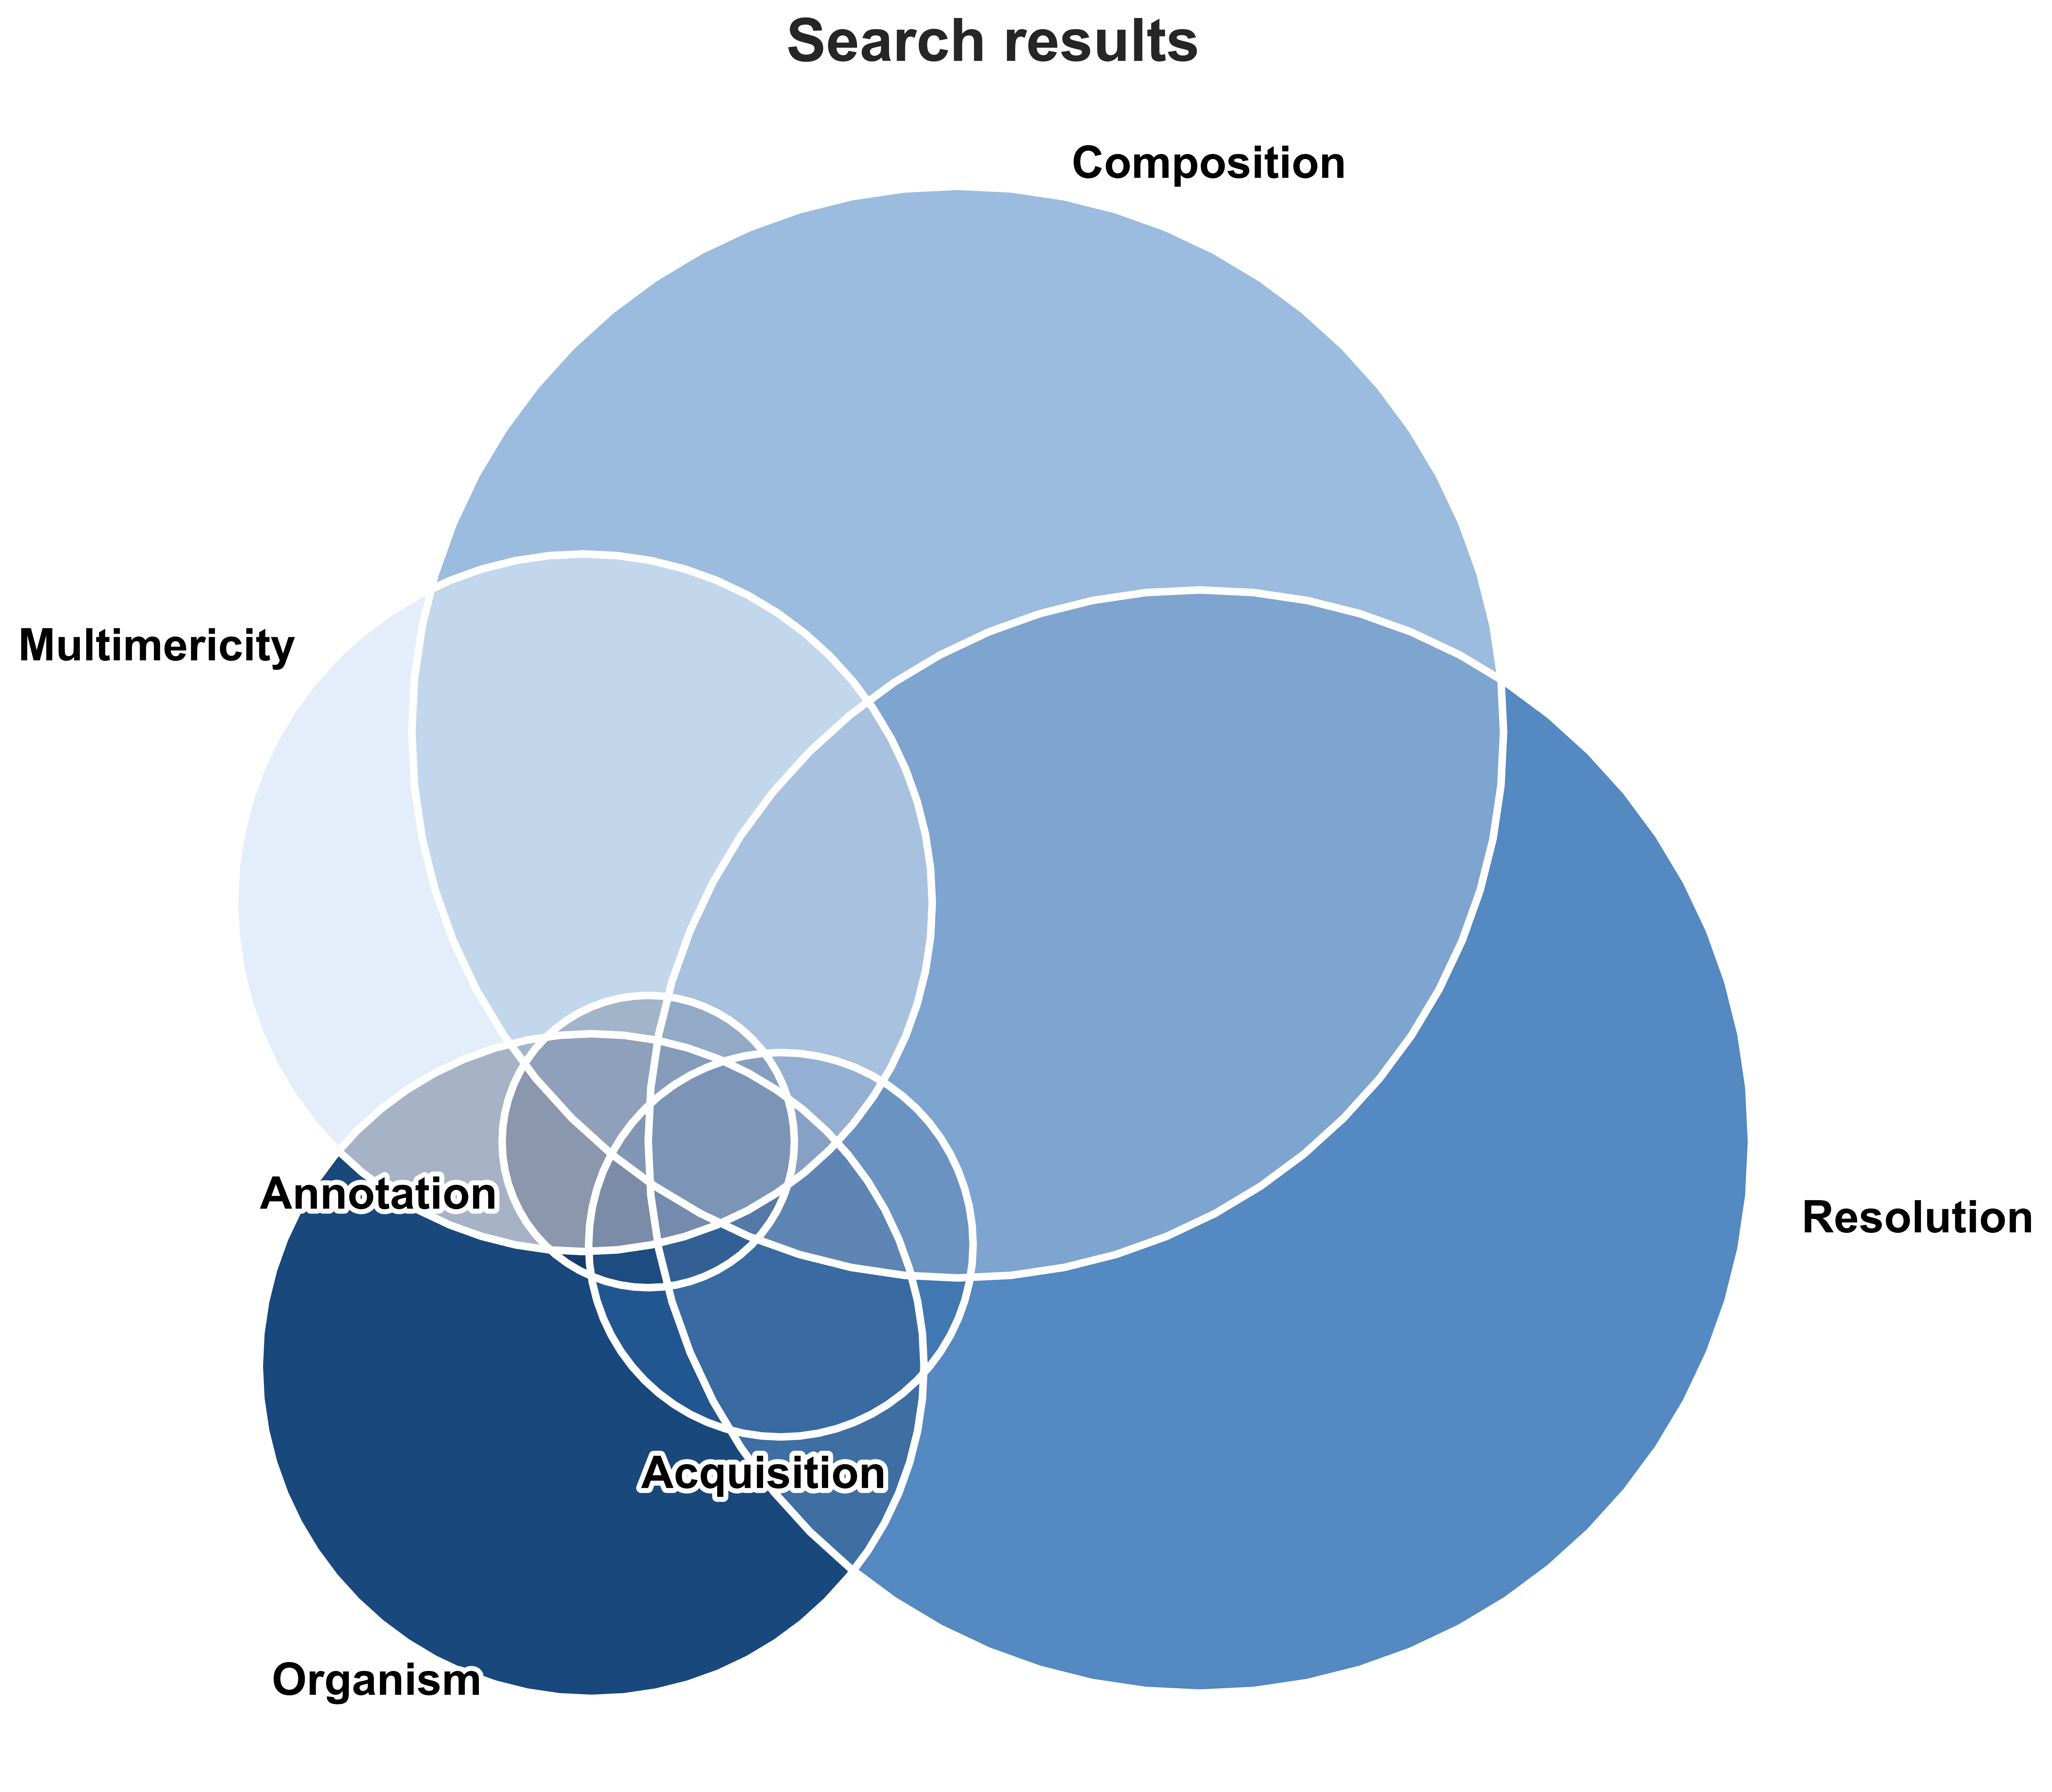

In [28]:
### VISUALIZE SEARCH RESULTS

sns.set_theme(style="white", context="talk")
fig, ax = plt.subplots(figsize=(12, 12), dpi=600)

diagram = EulerDiagram.from_sets(
    sets=[set(search) for search in result["search"].values()],
    set_labels=[search.capitalize() for search in result["search"].keys()],
    set_colors=sns.color_palette(TUM_BLUE_GRADIENT, len(result["search"])),
    subset_labels=False,
    ax=ax
)

for patch in diagram.subset_artists.values():
    patch.set_edgecolor("white")
    patch.set_linewidth(3)

for label in diagram.set_label_artists:
    label.set_fontsize(18)
    label.set_fontweight("bold")
    label.set_color("black")
    label.set_path_effects([
        path_effects.Stroke(linewidth=4, foreground="white"),
        path_effects.Normal()
    ])

plt.title("Search results", fontsize=24, fontweight="bold", pad=20)
plt.show()

fig.savefig("./results/search.png", bbox_inches="tight", format="png")

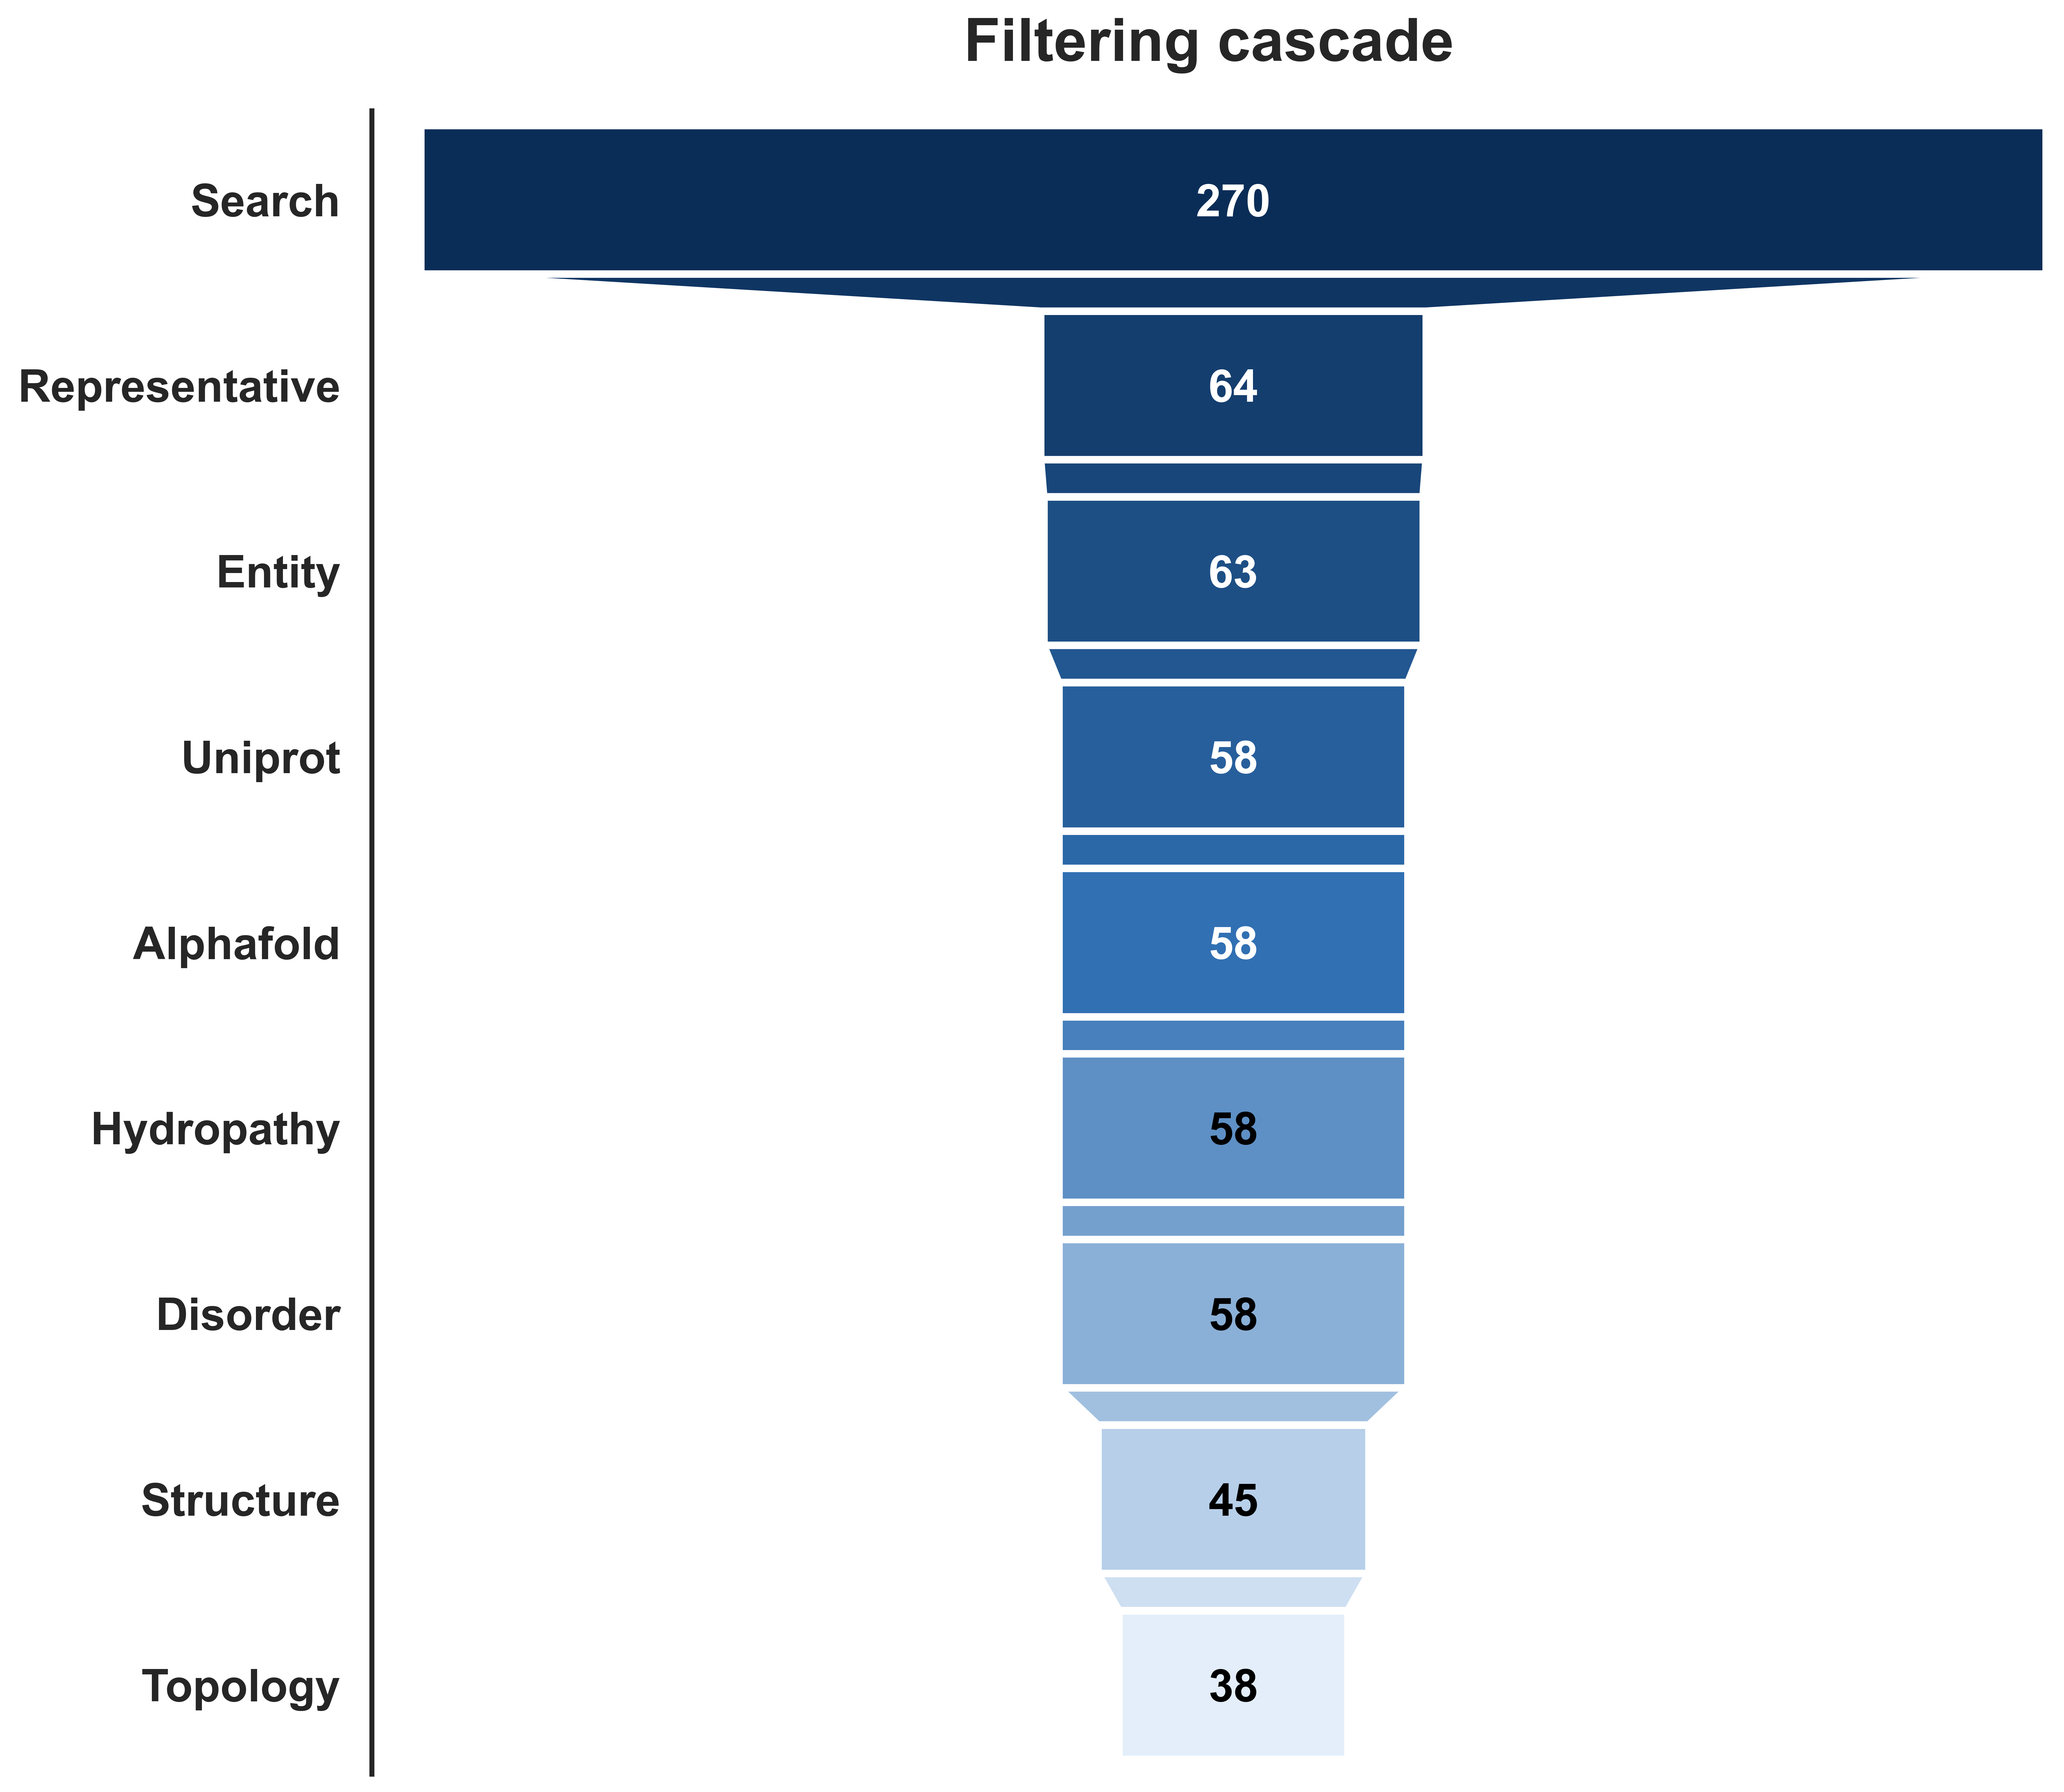

In [29]:
### VISUALIZE FILTER RESULTS

sns.set_theme(style="white", context="talk")
fig, ax = plt.subplots(figsize=(12, 12), dpi=600)

counts = [len(result["summary"]["search"])] + [len(filter) for filter in result["filter"].values()]
labels = ["Search"] + [filter.capitalize() for filter in result["filter"].keys()]
colors = cast(list, sns.color_palette(TUM_BLUE_GRADIENT, 2*len(counts)-1))

height=0.8
positions = list(range(len(labels), 0, -1))
adjust = [(max(counts)-count)/2 for count in counts]

for key, val, pos, adj, col in zip(labels, counts, positions, adjust, colors[::2]):
    plt.barh(
        y=pos,
        width=val,
        height=height,
        left=adj,
        color=col,
        linewidth=3,
        edgecolor="white"
    )
    plt.text(
        x=max(counts)/2,
        y=pos,
        s=str(val),
        ha='center',
        va='center_baseline',
        fontsize=18,
        fontweight="bold",
        color='white' if (col[0] * 0.299 + col[1] * 0.587 + col[2] * 0.114) < 0.5 else 'black'
    )

transition = [
    (
        [adjust[i], adjust[i+1], adjust[i+1] + counts[i+1], adjust[i] + counts[i]],
        [positions[i] - height/2, positions[i+1] + height/2, positions[i+1] + height/2, positions[i] - height/2]
    )
    for i in range(len(counts)-1)
]

for tr, col in zip(transition, colors[1::2]):
    plt.fill(tr[0], tr[1], color=col, linewidth=3, edgecolor="white")

ax.spines["left"].set_visible(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.spines["left"].set_linewidth(2)

ax.set_xticks([])
ax.set_yticks(positions, labels, fontsize=18, fontweight="bold")

plt.xlim(-max(counts)*0.03, max(counts))
plt.ylim(1-height*0.6, len(labels)+height*0.6)

plt.title("Filtering cascade", fontsize=24, fontweight="bold", pad=20)
plt.show()

fig.savefig("./results/filter.png", bbox_inches="tight", format="png")